In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_chats = pd.read_csv('cleaned_data/chats_final_with_clusters.csv')
X = df_chats['cleaned_question']
Y = df_chats['cluster']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
# Replace missing values with empty strings
X_train = X_train.fillna("")
X_test = X_test.fillna("")


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9, min_df=2, ngram_range=(1,2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [9]:
# Logestic Regression Model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, Y_train)
y_pred = model.predict(X_test_tfidf)

Model Accuracy: 0.9955
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1963
           1       1.00      0.99      1.00       124
           2       1.00      0.98      0.99        92
           3       1.00      0.17      0.29         6
           4       1.00      0.90      0.95        20

    accuracy                           1.00      2205
   macro avg       1.00      0.81      0.84      2205
weighted avg       1.00      1.00      0.99      2205



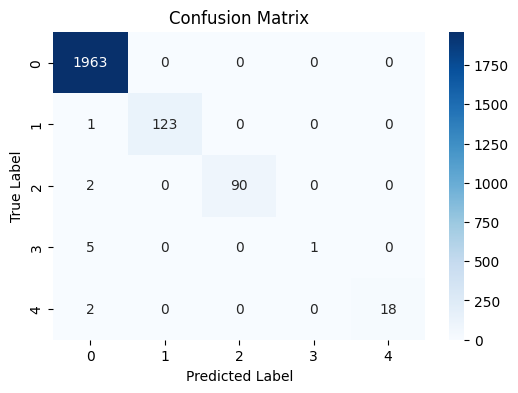

In [10]:
# evaluate the model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt

# 1. Accuracy Score
accuracy = accuracy_score(Y_test, y_pred)
print(f'Model Accuracy: {accuracy:.4f}')

# 2. Classification Report
print('Classification Report:')
report = classification_report(Y_test, y_pred)
print(report)

# 3. Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


SVC Model Accuracy: 0.9986
SVC Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1963
           1       1.00      1.00      1.00       124
           2       1.00      0.99      0.99        92
           3       1.00      0.67      0.80         6
           4       1.00      1.00      1.00        20

    accuracy                           1.00      2205
   macro avg       1.00      0.93      0.96      2205
weighted avg       1.00      1.00      1.00      2205



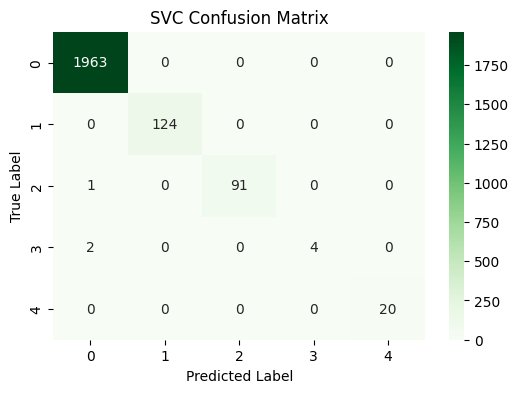

In [12]:
# LinearSVC model
from sklearn.svm import LinearSVC

model_svc = LinearSVC(random_state=42)
model_svc.fit(X_train_tfidf, Y_train)
y_pred_svc = model_svc.predict(X_test_tfidf)
# evaluate the SVC model

# 1. Accuracy Score
accuracy_svc = accuracy_score(Y_test, y_pred_svc)
print(f'SVC Model Accuracy: {accuracy_svc:.4f}')
# 2. Classification Report
print('SVC Classification Report:') 
report_svc = classification_report(Y_test, y_pred_svc)
print(report_svc)
# 3. Confusion Matrix
cm_svc = confusion_matrix(Y_test, y_pred_svc)
plt.figure(figsize=(6,4))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Greens')
plt.title('SVC Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
import joblib
# Save the Svc model
joblib.dump(model_svc, 'models/intent_recognition_model_svc.pkl')
# Save the vectorizer
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')

print("Models and vectorizer saved successfully.")

Models and vectorizer saved successfully.


In [14]:
def predict_intent(text):
    # 1️⃣ Clean the text (same cleaning logic you used before)
    import re, string
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))

    text = str(text).lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # 2️⃣ Transform with the trained vectorizer
    X_new = vectorizer.transform([text])

    # 3️⃣ Predict intent
    cluster = model_svc.predict(X_new)[0]

    # 4️⃣ (Optional) Map cluster number → topic name
    cluster_labels = {
        0: "Multilingual / General Requests",
        1: "Technical or Logical Questions",
        2: "Greetings & General Conversation",
        3: "Personal or Emotional Chat",
        4: "Thanks & Closing Messages"
    }

    intent = cluster_labels.get(cluster, "Unknown")
    return cluster, intent


In [15]:
examples = [
    "Hey, how are you?",
    "When is the next flight to Paris?",
    "Can you help me fix my code?",
    "Thank you so much for your help!",
    "keefak habibi",
    "I love how you talk to me"
]

for msg in examples:
    cluster, intent = predict_intent(msg)
    print(f"Message: {msg}\nPredicted Intent: {intent} (Cluster {cluster})\n")


Message: Hey, how are you?
Predicted Intent: Multilingual / General Requests (Cluster 0)

Message: When is the next flight to Paris?
Predicted Intent: Multilingual / General Requests (Cluster 0)

Message: Can you help me fix my code?
Predicted Intent: Multilingual / General Requests (Cluster 0)

Message: Thank you so much for your help!
Predicted Intent: Thanks & Closing Messages (Cluster 4)

Message: keefak habibi
Predicted Intent: Multilingual / General Requests (Cluster 0)

Message: I love how you talk to me
Predicted Intent: Personal or Emotional Chat (Cluster 3)

